In [19]:
%matplotlib inline

import math
import time
import numpy as np
import pandas as pd
import pandas_datareader as pdr

import keras
from keras.layers import LSTM
from keras.models import Sequential
from keras.layers.wrappers import TimeDistributed
from keras.layers.core import Dense, Activation, Dropout
from keras.preprocessing.sequence import pad_sequences

from sklearn.metrics import mean_squared_error

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('whitegrid')
sns.set_context('talk')

params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'}

plt.rcParams.update(params)

## Set Parameters

In [4]:
# get stock price information 
def get_stock_data(index_name, start, end, retry_attempts = 3):   
    if index_name:
        while retry_attempts > 0 :
            try:
                df = pdr.get_data_yahoo(index_name, start, end)
                new_df = df.reindex(index=pd.date_range(df.index.min(), 
                                          df.index.max(), 
                                          freq='D')).fillna(method='ffill')
                retry_attempts = 0
                return new_df
            except Exception  as e:
                print("Data pull failed for {}. {} retry attempts remaining".\
                      format(e, retry_attempts))
                retry_attempts = retry_attempts - 1
    else:
        print("Invalid usage. Parameter index_name is required")
    return None

## Getting Data

In [5]:
import datetime

STOCK_INDEX = '^GSPC'

start = datetime.datetime(1970, 1, 1)
end = datetime.datetime(2018, 8, 12)
sp_df = get_stock_data(STOCK_INDEX, start, end)

In [6]:
sp_df.describe()

,High,Low,Open,Close,Volume,Adj Close
count,17753.000000,17753.000000,17753.000000,17753.000000,1.775300e+04,17753.000000
mean,765.252545,756.028657,760.783754,760.967160,1.267919e+09,760.967160
std,685.716939,679.008065,682.495920,682.610913,1.693359e+09,682.610913
min,63.230000,60.959999,62.279999,62.279999,6.650000e+06,62.279999
25%,131.740005,129.039993,130.339996,130.479996,5.460000e+07,130.479996
50%,462.470001,459.510010,461.269989,461.279999,2.873700e+08,461.279999
75%,1259.839966,1240.709961,1252.000000,1251.699951,2.259130e+09,1251.699951
max,2872.870117,2855.919922,2867.229980,2872.870117,1.145623e+10,2872.870117


C:\local\Anaconda3-4.1.1-Windows-x86_64\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: fill_method is deprecated to .resample()
the new syntax is .resample(...).ffill()
  


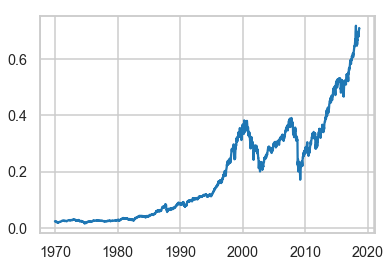

In [184]:
sp_close_series = sp_df.Close/4000.0
sp_close_series = sp_close_series.resample('W', fill_method='ffill')
sp_close_series.plot()

In [185]:
len(sp_close_series)

2537

In [186]:
my_data = sp_close_series.values

In [187]:
my_data = my_data[..., np.newaxis]


In [188]:
my_data[-20:]

array([[0.66021753],
       [0.65111749],
       [0.66407501],
       [0.66753497],
       [0.66747748],
       [0.66585498],
       [0.68192999],
       [0.67824249],
       [0.68033252],
       [0.68365503],
       [0.69475751],
       [0.69491498],
       [0.68871997],
       [0.67959253],
       [0.68995502],
       [0.70032751],
       [0.70045752],
       [0.70470502],
       [0.71008752],
       [0.70832001]])

## Preprocessing Data

In [251]:
from sklearn.preprocessing import MinMaxScaler

# prepare training and testing data sets for LSTM based sequence modeling
def get_seq_train_test(time_series, splits=[-1, 0, 52]):
    validation_size = splits[1]
    test_size = splits[2]
    train_size = len(time_series) - validation_size - test_size
    
    train = time_series[0:train_size]
    validation = time_series[train_size:train_size+validation_size]
    test = time_series[validation_size+test_size:]
    
    return train, validation, test

In [252]:
# split train and test datasets
train, validation, test = get_seq_train_test(my_data)

train = np.reshape(train, (1, train.shape[0], 1))
validation = np.reshape(validation, (1, validation.shape[0], 1))
test = np.reshape(test, (1, test.shape[0], 1))

train_x = train[:,:-1,:]
train_y = train[:,1:,:]

validation_x = validation[:,:-1,:]
validation_y = validation[:,1:,:]

test_x = test[:,:-1,:]
test_y = test[:,1:,:]

print("Data Split Complete")

print("train_x shape={}".format(train_x.shape))
print("train_y shape={}".format(train_y.shape))

print("validation_x shape={}".format(validation_x.shape))
print("validation_y shape={}".format(validation_y.shape))

print("test_x shape={}".format(test_x.shape))
print("test_y shape={}".format(test_y.shape))

Data Split Complete
train_x shape=(1, 2484, 1)
train_y shape=(1, 2484, 1)
validation_x shape=(1, 0, 1)
validation_y shape=(1, 0, 1)
test_x shape=(1, 2484, 1)
test_y shape=(1, 2484, 1)


## Prepare LSTM Model

In [253]:
# Get stacked LSTM model for sequence modeling
def create_seq_model(hidden_units=4, input_shape=(1,1)):
    # create and fit the LSTM network
    model = Sequential()
    # samples*timesteps*featuress

    model.add(LSTM(input_shape=input_shape, 
                   units = hidden_units, 
                   return_sequences=True
    ))
    
    # readout layer. TimeDistributedDense uses the same weights for all
    # time steps.
    model.add(TimeDistributed(Dense(1)))

    return model

In [254]:
# build RNN model
seq_lstm_model = create_seq_model(input_shape=(train_x.shape[1], 1))
print(seq_lstm_model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 2484, 4)           96        
_________________________________________________________________
time_distributed_12 (TimeDis (None, 2484, 1)           5         
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________
None


## Fit the Model

In [255]:
# Pad input sequence
validation_x = pad_sequences(validation_x,
                                maxlen=train_x.shape[1],
                                padding='post',
                                dtype='float64')

validation_y = pad_sequences(validation_y,
                                maxlen=train_y.shape[1],
                                padding='post',
                                dtype='float64')

In [256]:
# train the model
# use eatrly stopping to avoid overfitting    
lr = 0.01

optimizer = keras.optimizers.RMSprop(lr=lr)
seq_lstm_model.compile(loss="mse", optimizer=optimizer)

# callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss',
#                                           patience=5,
#                                           verbose=0)]

seq_lstm_model.fit(train_x, train_y, 
#                   validation_data = [validation_x, validation_y],
#                   callbacks=callbacks,
                   epochs=20, 
                   batch_size=1, 
                   verbose=2)

Epoch 1/20
 - 3s - loss: 0.0531
Epoch 2/20
 - 1s - loss: 0.0206
Epoch 3/20
 - 1s - loss: 0.0136
Epoch 4/20
 - 1s - loss: 0.0108
Epoch 5/20
 - 1s - loss: 0.0080
Epoch 6/20
 - 1s - loss: 0.0053
Epoch 7/20
 - 1s - loss: 0.0028
Epoch 8/20
 - 1s - loss: 0.0010
Epoch 9/20
 - 1s - loss: 3.6467e-04
Epoch 10/20
 - 1s - loss: 0.0013
Epoch 11/20
 - 1s - loss: 0.0070
Epoch 12/20
 - 1s - loss: 0.0045
Epoch 13/20
 - 1s - loss: 0.0036
Epoch 14/20
 - 1s - loss: 8.5273e-04
Epoch 15/20
 - 1s - loss: 5.0179e-04
Epoch 16/20
 - 1s - loss: 3.3687e-04
Epoch 17/20
 - 1s - loss: 3.1271e-04
Epoch 18/20
 - 1s - loss: 3.0906e-04
Epoch 19/20
 - 1s - loss: 3.6973e-04
Epoch 20/20
 - 1s - loss: 4.5810e-04


## Train Prediction Performance

In [257]:
# train fit performance
trainPredict = seq_lstm_model.predict(train_x)
trainScore = math.sqrt(mean_squared_error(train_y[0], trainPredict[0]))
print('Train Score: %.2f RMSE' % (trainScore))

Train Score: 0.03 RMSE


## Test Prediction Performance

In [258]:
# Pad input sequence
testPredict = pad_sequences(test_x,
                                maxlen=train_x.shape[1],
                                padding='post',                            
                                dtype='float64')

In [259]:
# forecast values
testPredict = seq_lstm_model.predict(testPredict)

# evaluate performances
testScore = math.sqrt(mean_squared_error(test_y[0], 
                                         testPredict[0][:test_x.shape[1]]))
print('Test Score: %.2f RMSE' % (testScore))

Test Score: 0.03 RMSE


## Plot Test Predictions

In [260]:
# Pad input sequence
test = my_data[-52*2:]
test = np.reshape(test, (1, test.shape[0], 1))

testPredict = pad_sequences(test,
                                maxlen=train_x.shape[1],
                                padding='post',                            
                                dtype='float64')

In [261]:
print(test.shape)

(1, 104, 1)


In [262]:
# forecast values
testPredict = seq_lstm_model.predict(testPredict)

In [263]:
# # inverse transformation
# trainPredict = scaler.inverse_transform(trainPredict.\
#                                         reshape((trainPredict.shape[1], trainPredict.shape[2])))
# testPredict = scaler.inverse_transform(testPredict.\
#                                        reshape((testPredict.shape[1], testPredict.shape[2])))

trainPlot = trainPredict.reshape((trainPredict.shape[1], trainPredict.shape[2]))*4000
testPlot = testPredict.reshape((testPredict.shape[1], testPredict.shape[2]))*4000

In [266]:
print(trainPlot[-20:])
print(testPlot[52:106])

[[2205.9678]
 [2213.148 ]
 [2216.8096]
 [2216.484 ]
 [2221.6785]
 [2230.3037]
 [2237.4153]
 [2241.194 ]
 [2243.8809]
 [2252.5676]
 [2261.1   ]
 [2265.6414]
 [2270.6643]
 [2275.9036]
 [2277.8303]
 [2281.2188]
 [2289.5242]
 [2296.0684]
 [2300.7795]
 [2305.8535]]
[[2302.9622]
 [2306.717 ]
 [2313.7676]
 [2314.7136]
 [2323.1104]
 [2327.4158]
 [2333.8948]
 [2342.876 ]
 [2348.882 ]
 [2357.475 ]
 [2364.1453]
 [2370.7622]
 [2375.3035]
 [2379.4478]
 [2387.1782]
 [2398.087 ]
 [2405.6746]
 [2415.4658]
 [2423.1804]
 [2428.0278]
 [2443.9211]
 [2458.0776]
 [2470.4688]
 [2488.7356]
 [2482.7095]
 [2466.9617]
 [2483.2766]
 [2488.8604]
 [2484.3323]
 [2499.9045]
 [2499.2703]
 [2477.9204]
 [2482.4202]
 [2475.3132]
 [2480.2485]
 [2481.4746]
 [2481.2405]
 [2480.0493]
 [2489.1702]
 [2488.8809]
 [2491.4978]
 [2495.005 ]
 [2503.5193]
 [2507.0144]
 [2506.6226]
 [2503.3723]
 [2510.153 ]
 [2518.2302]
 [2521.634 ]
 [2527.2915]
 [2533.8997]
 [2536.778 ]
 [2088.6147]
 [1924.3822]]


Train size 2485 test size 104


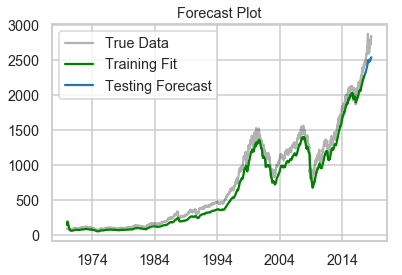

In [267]:
# plot the true and forecasted values
shift = 1
train_size = train_x.shape[1] + shift
test_size = test.shape[1]
print('Train size %d test size %d' % (train_size, test_size))
#print(testPredict[52:52*2])

plt.plot(sp_close_series.index,
         sp_close_series.values*4000,c='black',
         alpha=0.3,label='True Data')

plt.plot(sp_close_series.index[1:train_size],
         trainPlot, label='Training Fit',c='g')

plt.plot(sp_close_series.index[-test_size+52:],
         testPlot[52:test_size],label='Testing Forecast')

plt.title('Forecast Plot')
plt.legend()
plt.show()
